El objetivo es construir un modelo para escanear la imagen de un ojo de un paciente y encontrar si el género del paciente es masculino o femenino.

**Primero importamos las librerias:**

In [ ]:
#librerias
import os, cv2, zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from numpy.ma.core import resize
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from google.colab import files
%matplotlib inline

**Se descargan las imagenes**

Este documento es creado para el bootcamp de deep learning de DPhi. El conjunto de datos proviene de Ruskino RU, PavelBi.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1f7uslI-ZHidriQFZR966_aILjlkgDN76' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1f7uslI-ZHidriQFZR966_aILjlkgDN76" -O eye_gender_data.zip && rm -rf /tmp/cookies.txt
local_zip = '/content/eye_gender_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

--2022-04-30 02:40:04--  https://docs.google.com/uc?export=download&confirm=t&id=1f7uslI-ZHidriQFZR966_aILjlkgDN76
Resolving docs.google.com (docs.google.com)... 108.177.11.100, 108.177.11.139, 108.177.11.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.11.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7298p1110rs9sich0d3t5baap8j4mmnp/1651286400000/03712597189317496002/*/1f7uslI-ZHidriQFZR966_aILjlkgDN76?e=download [following]
--2022-04-30 02:40:04--  https://doc-0c-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7298p1110rs9sich0d3t5baap8j4mmnp/1651286400000/03712597189317496002/*/1f7uslI-ZHidriQFZR966_aILjlkgDN76?e=download
Resolving doc-0c-cc-docs.googleusercontent.com (doc-0c-cc-docs.googleusercontent.com)... 173.194.218.132, 2607:f8b0:400c:c14::84
Connecting to doc-0c-cc-docs.googleusercontent.com (doc-0c-c

**Carga de datos de entrenamiento**


In [ ]:
labels = pd.read_csv("/content/eye_gender_data/Training_set.csv") # loading the labels
file_paths = [[fname, '/content/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename') #si no esta en images y en label se elimina el dato

**Preparación de datos de entrenamiento**

Se convierten los valores de femenino y masculino a 0 y 1.


Salidas esperadas son:  [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 

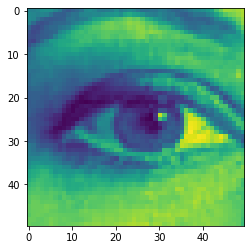

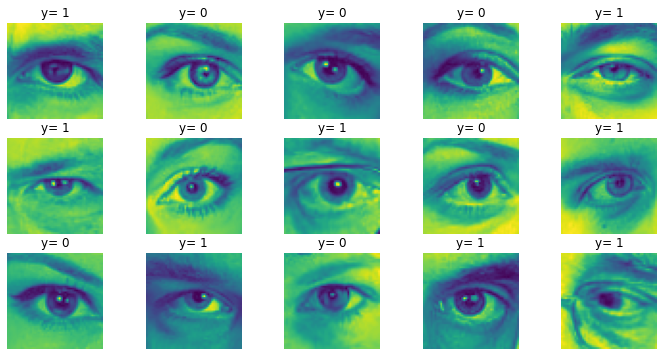

In [ ]:
image_size = 50 #seleccionar el tamaño de imagen
le = LabelEncoder()
train_data['label'] = le.fit_transform(train_data['label']) 
y = [] #Datos de salida
for i in range(len(train_data)): 
  y.append(train_data['label'][i])
print("Salidas esperadas son: ",y)
X = [] #Datos de entrada
for i in range(len(train_data)):
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) # convertir la imagen a escala de grises
  new_img_array = cv2.resize(img_array, (image_size, image_size)) # cambiar el tamaño de la matriz de imágenes
  X.append(new_img_array/255) #parametrización de la matriz de pixeles 
print("Entrada parametrizada",X[3])
print("========================================================================")
print("Ejemplo de uno de los datos de entrenamiento (pixeles del ojo) ") #Se esta viendo el ojo 4
plt.imshow(X[3])

print("Salida esperada es: ", y[3] )#Se muestra la salida 4, que corresponderia a un ojo femenino.
print("Tamaño de la imagen", image_size ,"x",image_size )
print("========================================================================")
# ver algunas entradas y salidas esperadas
num_rows, num_cols = 3, 5
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,6), squeeze=True)

for r in range(num_rows):
  for c in range(num_cols):
    image_index = r * 5 + c
    ax[r,c].axis("off")
    ax[r,c].imshow( X[image_index])
    ax[r,c].set_title('y = %d' % y[image_index])
plt.show()
plt.close()
# En el futuro se podrian generar mas dastos(imagenes) apartir de las imagenes, por ejemplo rotandolas

**División de datos en entrenamiento y validación**

Los datos se dividen en dos conjuntos uno entrenamiento y otro de validación, en una proporción de 80:20.

In [ ]:
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_flattened = X_train.reshape(len(X_train), image_size*image_size)
X_test_flattened = X_test.reshape(len(X_test), image_size*image_size)

**Construcción del modelo I**

In [ ]:
model = tf.keras.models.Sequential()
model.add(Dense(800, activation='relu', input_shape = (image_size*image_size,)))
model.add(Dense(400, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 800)               2000800   
                                                                 
 dense_1 (Dense)             (None, 400)               320400    
                                                                 
 dense_2 (Dense)             (None, 200)               80200     
                                                                 
 dense_3 (Dense)             (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
 dense_6 (Dense)             (None, 2)                 2

**Construcción del modelo II**

In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(Dense(800, activation='relu', input_shape = (image_size*image_size,)))
model2.add(Dense(400, activation='relu'))
model2.add(Dropout(0.05))
model2.add(Dense(400, activation='relu'))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(rate=0.1))
model2.add(Dense(100,activation='relu', kernel_regularizer = 'l2'))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(rate=0.1))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 800)               2000800   
                                                                 
 dense_8 (Dense)             (None, 400)               320400    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_9 (Dense)             (None, 400)               160400    
                                                                 
 dense_10 (Dense)            (None, 100)               40100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 100)              

**Entrenamiento del modelo I**

In [ ]:
batch_size= 50
epochs=100
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_flattened, y_train, batch_size,epochs)

Epoch 1/100
148/148 [==============================] - 8s 41ms/step - loss: 0.6690 - accuracy: 0.5834
Epoch 2/100
148/148 [==============================] - 7s 44ms/step - loss: 0.5565 - accuracy: 0.7185
Epoch 3/100
148/148 [==============================] - 4s 24ms/step - loss: 0.5216 - accuracy: 0.7462
Epoch 4/100
148/148 [==============================] - 4s 24ms/step - loss: 0.5014 - accuracy: 0.7599
Epoch 5/100
148/148 [==============================] - 4s 24ms/step - loss: 0.4703 - accuracy: 0.7817
Epoch 6/100
148/148 [==============================] - 4s 24ms/step - loss: 0.4582 - accuracy: 0.7912
Epoch 7/100
148/148 [==============================] - 4s 24ms/step - loss: 0.4255 - accuracy: 0.8124
Epoch 8/100
148/148 [==============================] - 4s 24ms/step - loss: 0.4078 - accuracy: 0.8189
Epoch 9/100
148/148 [==============================] - 4s 24ms/step - loss: 0.4160 - accuracy: 0.8160
Epoch 10/100
148/148 [==============================] - 4s 24ms/step - loss: 0.414

**Entrenamiento del modelo II**

In [ ]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train_flattened, y_train, batch_size,epochs,)

Epoch 1/100
148/148 [==============================] - 5s 27ms/step - loss: 1.1974 - accuracy: 0.5492
Epoch 2/100
148/148 [==============================] - 4s 27ms/step - loss: 0.7405 - accuracy: 0.7043
Epoch 3/100
148/148 [==============================] - 4s 27ms/step - loss: 0.5887 - accuracy: 0.7507
Epoch 4/100
148/148 [==============================] - 4s 27ms/step - loss: 0.5071 - accuracy: 0.7877
Epoch 5/100
148/148 [==============================] - 4s 27ms/step - loss: 0.4638 - accuracy: 0.8060
Epoch 6/100
148/148 [==============================] - 4s 27ms/step - loss: 0.4402 - accuracy: 0.8109
Epoch 7/100
148/148 [==============================] - 4s 27ms/step - loss: 0.4286 - accuracy: 0.8130
Epoch 8/100
148/148 [==============================] - 4s 26ms/step - loss: 0.4098 - accuracy: 0.8262
Epoch 9/100
148/148 [==============================] - 4s 27ms/step - loss: 0.4092 - accuracy: 0.8225
Epoch 10/100
148/148 [==============================] - 4s 27ms/step - loss: 0.410

**Evaluación del modelo I**


In [ ]:
model.evaluate(X_test_flattened,y_test)

58/58 [==============================] - 1s 9ms/step - loss: 0.4224 - accuracy: 0.8736


[0.4223932921886444, 0.873644232749939]

**Evaluación del modelo II**

In [ ]:
model2.evaluate(X_test_flattened,y_test)

58/58 [==============================] - 1s 8ms/step - loss: 0.3847 - accuracy: 0.8476


[0.3846677243709564, 0.8476138710975647]

**Carga de datos de predicción**

In [ ]:
labels_test = pd.read_csv("/content/eye_gender_data/Testing_set.csv") 
file_paths_test = [[fname, '/content/eye_gender_data/test/' + fname] for fname in labels_test['filename']]
images_test = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])
test_data = pd.merge(images_test, labels_test, how = 'inner', on = 'filename')

**Preparación de datos de predicción**

In [ ]:
X_t= []
for i in range(len(test_data)):
  img_array_test = cv2.imread(test_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)
  new_img_array_test = cv2.resize(img_array_test, (image_size, image_size))
  X_t.append(new_img_array_test/255)
  
X_t = np.array(X_t)
X_t_flattened = X_t.reshape(len(X_t), image_size*image_size)

**Predicción**

In [ ]:
pred = model2.predict(X_t_flattened)

prediction = []
for value in pred:
  prediction.append(np.argmax(value))

**Reinvertir la parametrización**

In [ ]:
predictions = le.inverse_transform(prediction)

**Descargar la predicción**

In [ ]:
res = pd.DataFrame({'filename': images_test['filename'], 'label': predictions})
res.to_csv("submission.csv", index = False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>